# Anexo
Notebook contendo os códigos e análises executados

** IMPORTANTE: ** O passo 1.1 contém os comandos utilizados para consultar e tratar os dados no MongoDB. Na ausência do banco de dados Mongo com os dados de origem, ** pular o passo 1.1 **. No passo 1.3 os dados tratados são lidos de uma planilha CSV, dispensando o uso do MongoDB.

In [2]:
import pandas as pd
import numpy as np

from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

import networkx as nx 

pd.set_option('display.max_colwidth',300)

In [3]:
#Plotar gráfico de colunas
def draw_graph_count(df, col):
    ax = sns.countplot(x=col, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

#Plotar nuvem de palavras
def draw_word_cloud(tokens):
    texto_cloud = ' '.join(tokens)
    wc = WordCloud(width = 600, height = 600, background_color ='white', min_font_size = 10, collocations=False).generate(texto_cloud) 
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 
    plt.show()


#Plotar gŕafico de rede ou grafo
def draw_network(df, nodes, source, target):
    G = nx.from_pandas_edgelist(df=df, source=source, target=target)
    G.add_nodes_from(nodes_for_adding=nodes.tolist())
    nx.draw(G, with_labels = True, node_color='lightgrey', node_size = 500, font_size = 10)

# 1. Carga e preparação dos dados

## 1.1 Consulta e preparação dos Tweets salvos no Mongo

Conexão e consulta dos tweets salvos mongodb a partir da coleta via streming utilizando o Apache NiFi. Carga dos dados no pandas dataframe.

In [36]:
df_tweets = pd.read_csv("tweets.csv")

In [40]:
df_tweets['timestamp'].head(2)

0    2019-09-14 15:52:04
1    2019-09-14 15:31:38
Name: timestamp, dtype: object

Tratamento inicial dos dados como: converter de timestamp para data e hora, retirar links dos textos, coletar nome dos usuários que foram retweetados, retirar pontuações

In [42]:
#'Sat Sep 14 15:31:38 +0000 2019'

#df_tweets['timestamp']
df_tweets["tempo"] = pd.to_datetime(df_tweets['timestamp'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize('America/Sao_Paulo')
df_tweets["data"] = df_tweets["tempo"].dt.date

df_tweets["texto"] = df_tweets["texto"].str.replace('https:\/\/.*\s?','')
df_tweets["texto"] = df_tweets["texto"].str.replace('\\r|\\n','')

df_tweets["user_retweeted"] = df_tweets["texto"].str.extract('^RT \@([\w]+)\:', expand=False)
df_tweets["user_retweeted"] = df_tweets["user_retweeted"].fillna("")

In [43]:
from string import punctuation

p_custom = '-#()🤰—|\"\'?,;!.…¿📈😁👍🏽🌐🙏⚡️💸🆙“”😂😑❤😊😍🌻🔝😬🔌♥:🤦‍♂*😒😭😱🤣🎭🙃' 
df_tweets["texto"] = df_tweets["texto"].str.translate(str.maketrans('', '', p_custom))

Salvando csv dos tweets tratados

In [ ]:
df_tweets.columns = ['id','text','timestamp_ms','user_followers_count','user_friends_count','user_location','user_screen_name','tempo','data','user_retweeted']
df_tweets.to_csv(path_or_buf='tweets.csv', index=False)

## 1.2 Carga do Dicionário de Palavras e Polaridade

Carga e parse do arquivo contendo palavras e polaridades
Criação de um dicionário contendo palavra e polaridade

In [3]:
df_arq = pd.read_csv('SentiLex-PT02/SentiLex-flex-PT02.txt', header=None, names=['col'], sep='#')
df_arq = df_arq[~df_arq.col.str.contains("IDIOM")]

df_sentilex = df_arq.col.str.extract(r'^(?P<palavra>.*),.*\.PoS.*=(?P<polaridade>.?[0-9]);ANOT', expand=True)
df_sentilex = pd.Series(df_sentilex.polaridade.values,index=df_sentilex.palavra).to_dict()


## 1.3 Criando DataFrame com os tokens extraídos dos Tweets

In [4]:
df_tweets = pd.read_csv('tweets.csv')
df_tweets[['id','text', 'user_followers_count','user_friends_count','user_location','user_screen_name','data','user_retweeted']].head(5)

,id,text,user_followers_count,user_friends_count,user_location,user_screen_name,data,user_retweeted
0,1107042314097229824,CEMIG ta vacilona hoje em assim não dá,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,NaN
1,1107052443580420096,Ficar sem luz e foda essa loja da Cemig,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,NaN
2,1107053694523228160,Cemig zuando os pratence hihihi,382,295,ciúmentolandia,sou_geise,2019-03-16,NaN
3,1107072220281688064,BETHEVITAS mxrcone CEMIG curtiu isso,1461,1466,"Minas Gerais, Brasil",jkbrunno,2019-03-17,NaN
4,1107098836516962305,Recado dos Eletricitários em defesa da CEMIG FNU,63,1697,Rio de Janeiro - Brasil,magu5,2019-03-17,NaN


In [5]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

#Definindo as stopwords
df_tokens = pd.DataFrame()
w_custom = list(['cemig','rt','pra','r','é','tá'])

sw = set(stopwords.words('portuguese') + w_custom)

#Iterando sobre os tweets para coleta dos tokens
for index, row in df_tweets.iterrows():
    palavras = word_tokenize(str(row['text']).lower())
    
    df_token_tmp = pd.DataFrame()
    df_token_tmp["tokens"] = [palavra for palavra in palavras if palavra not in sw]
    df_token_tmp["id"] = row['id']
    
    #atribuição da polaridade com base no dicionáiro
    df_token_tmp["polaridade"] = df_token_tmp["tokens"].apply(df_sentilex.get)
    
    df_tokens = df_tokens.append(df_token_tmp, ignore_index=True)

#Cria dataframe contendo tokens e demais informações dos tweets
df_tweets_tokens = df_tokens.set_index('id').join(df_tweets.set_index('id'))
df_tweets_tokens = df_tweets_tokens.fillna('0')


In [6]:
df_tweets_tokens[['tokens','polaridade','timestamp_ms','user_followers_count','user_friends_count','user_location','user_screen_name','data','user_retweeted']].head(10)

,tokens,polaridade,timestamp_ms,user_followers_count,user_friends_count,user_location,user_screen_name,data,user_retweeted
id,,,,,,,,,
1107042314097229824,ta,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,0
1107042314097229824,vacilona,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,0
1107042314097229824,hoje,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,0
1107042314097229824,assim,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,0
1107042314097229824,dá,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,0
1107052443580420096,ficar,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,0
1107052443580420096,luz,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,0
1107052443580420096,foda,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,0
1107052443580420096,loja,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,0


# Análise dos Dados

## Distribuição dos Tweets por dia

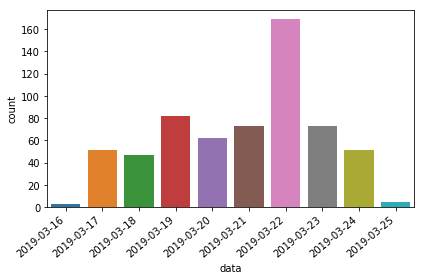

In [7]:
draw_graph_count(df_tweets, "data")

## Contagem de frequência das palavras

Listando as 10 mais frequentes

In [8]:
df_tweets_tokens.groupby('tokens').tokens.count().nlargest(10)

tokens
energia          61
luz              60
cmig4            54
cmign1           49
mil              41
renova           38
camarote         36
anos             32
independência    32
romeuzema        31
Name: tokens, dtype: int64

## Nuvem das palavras mais frequentes 

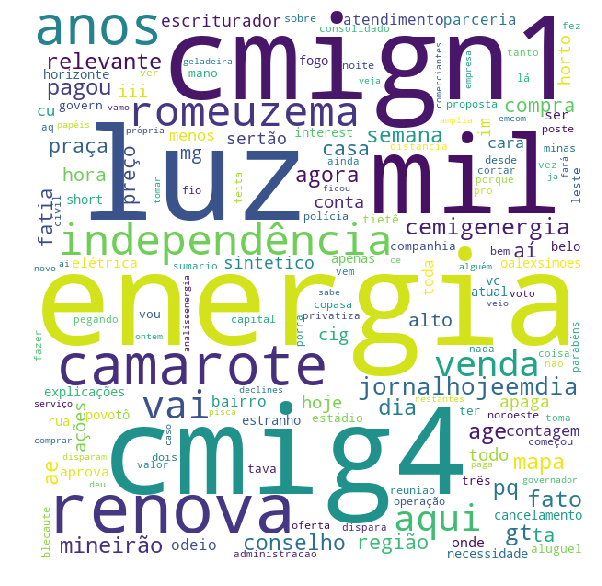

In [9]:
draw_word_cloud(df_tweets_tokens.tokens)

## CMIG4: Avaliando a ocorrência da palavra

In [10]:
df_cmig4 = df_tweets_tokens[['text','data']].loc[df_tweets_tokens['tokens'] == 'cmig4']
df_cmig4.head(5)

,text,data
id,,
1108315694775492609,Cemig para Abril de 2019 gráfico de CMIG4,2019-03-20
1108317267865952256,CMIG4 Cemig para Abril de 2019 TradingView,2019-03-20
1108936597116903424,CMIG4 RNEW11 Celebração de Contrato para Aquisição de Participação na Renova Energia SARenova e Realizaç,2019-03-22
1109062517735731200,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22
1109062519933554688,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22


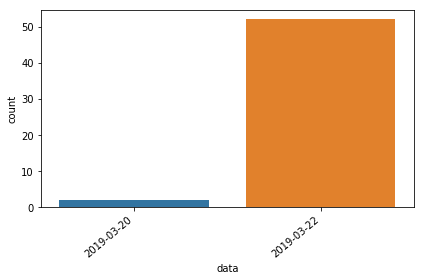

In [11]:
draw_graph_count(df_cmig4, "data")

O termo refere-se ao código do papel CEMIG negociado na bolsa de valores. Conforme observado na lista de tweets e data de propagação, tem relação com o informe de fato relevante encaminhado pela CEMIG ao mercado de ações.

## CAMAROTE: Avaliando a ocorrência palavra

In [12]:
df_camarote = df_tweets_tokens[['text','user_screen_name','data','user_retweeted']].loc[df_tweets_tokens['tokens'] == 'camarote']
df_camarote.head(5) 

,text,user_screen_name,data,user_retweeted
id,,,,
1109215677053837313,Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,jornalhojeemdia,2019-03-22,0
1109215897464512515,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,REGINALDOGALO10,2019-03-22,jornalhojeemdia
1109216983755698176,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,digaormf,2019-03-22,jornalhojeemdia
1109217168451883009,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,rafael_fr2,2019-03-22,jornalhojeemdia
1109218880659079170,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,sracansada,2019-03-22,jornalhojeemdia


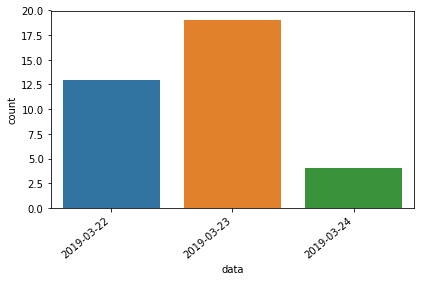

In [13]:
draw_graph_count(df_camarote, "data")

O termo tem relação com notícia veiculada pelo jornal Hoje em Dia, propagada entre os dias 22 e 24 de março. Segundo o jornal, a CEMIG teria pago o valor de 990 mil por 3 anos de camarote no estádio independência. Ainda segundo o jornal, o mesmo serviço poderia ter sido contratado no Minerião pelo valor de 390 mil.

Podemos observar que outros termos que aparecem na lista dos mais frequentes tem relação com esse mesmo fato: [mil, independência].

## Contagem de frequência das palavras com polaridade Negativa

Listando as 10 mais frequentes

In [14]:
df_tweets_tokens_neg = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '-1']
df_tweets_tokens_neg.groupby('tokens').tokens.count().nlargest(10)

tokens
venda       23
apaga       14
odeio       12
estranho    10
pisca        6
apagava      5
cair         5
caiu         5
derrotas     5
falta        5
Name: tokens, dtype: int64

## Nuvem das palavras mais frequentes com polaridade negativa  

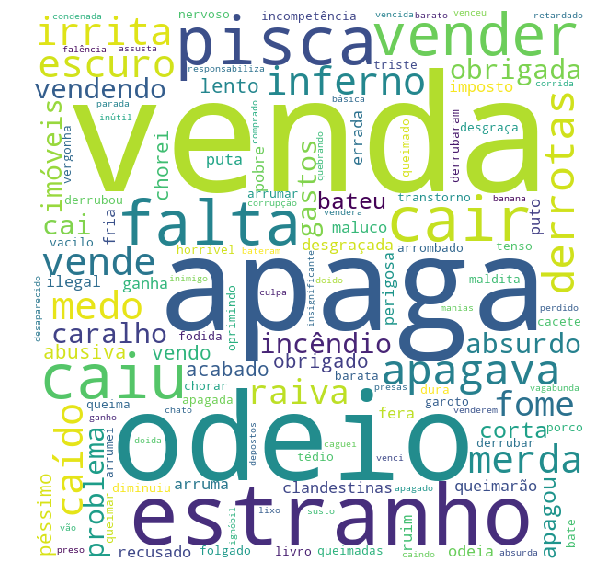

In [15]:
draw_word_cloud(df_tweets_tokens_neg.tokens)


## VENDA: Avaliando a ocorrência palavra

** Tweets **

In [16]:
df_venda = df_tweets_tokens_neg[['text','user_screen_name','user_retweeted','data']].loc[df_tweets_tokens_neg['tokens'] == 'venda']
df_venda.head(5)

,text,user_screen_name,user_retweeted,data
id,,,,
1107123548622123008,joaoamoedonovo até agora nada do novo ter anunciado a venda das 2 estatais CEMIG E COPASA que estão oprimindo o povo,Desmio,0,2019-03-17
1107656184926998528,Vejam o péssimo atendimento da Cemig 20 minutos para pegar uma senha de atendimento na Agência de Venda Nova,renato_artur,0,2019-03-18
1107657455771758592,RT renatoartur Vejam o péssimo atendimento da Cemig 20 minutos para pegar uma senha de atendimento na Agência de Venda NovaCEMIG htt,helberthadm,renato_artur,2019-03-18
1109060826328166400,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III,jornaltijucas,0,2019-03-22
1109061194986459136,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III,jornaltijucas,0,2019-03-22


** Distribuição **

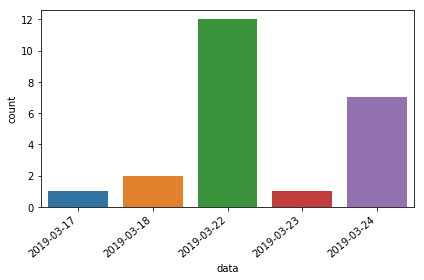

In [17]:
draw_graph_count(df_venda, "data")

A alta ocorrência do termo tem relação com dois fatos. O primeiro é a informação propagada no dia 22/03, de compra por parte da CEMIG de fatia da empresa Renova, e **venda** do complexo eólico de Alto Sertão III. Esse fato está relacionado ao comunicado enviado pela empresa ao mercado, no mesmo dia 22/03, razão da grande ocorrência do termo CMIG4, avaliado anteriormente.

Outra razão para alta ocorrência do termo tem origem nos tweets propagados no dia 24/03, relacionados à notícia de que a CEMIG está vendendo alguns de seus imóveis, e a reação de usuários à essa notícia, pedindo que o governador Romeu Zema aproveite a ocasião para vender (ou privatizar) a empresa.

## APAGA e ESTRANHO: Avaliando a ocorrência das palavras

** Tweets: APAGA **

In [18]:
df_apaga = df_tweets_tokens_neg[['text','user_screen_name','user_retweeted','data']].loc[df_tweets_tokens_neg['tokens'] == 'apaga']
df_apaga.head(5)

,text,user_screen_name,user_retweeted,data
id,,,,
1107133154068971521,BellaMoreira8 e a minha que tá o dia todo apaga a luz e deixa o tempo passar BABY VOCÊ NÃO PERDE POR ESPERAR APAG,JujubaMS,0,2019-03-17
1107417138879438849,Cemig se for pra piscar a luz de 10 em 10s apaga essa porra logo caralhoPelo menos não queima o resto do meu PC,danielpontello,0,2019-03-17
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga Decide logo se vai ter apagão ou não cemig,PinheiroRodson,0,2019-03-19
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga Decide logo se vai ter apagão ou não cemig,PinheiroRodson,0,2019-03-19
1109210554269384705,O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual,oalexsimoes,0,2019-03-22


** Distribuição: APAGA **

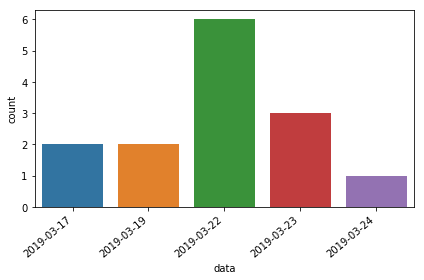

In [19]:
draw_graph_count(df_apaga, "data")


A maior ocorrência da palavra apaga está relacionada ao caso do camarote alugado pela CEMIG no independência, divulgado em um tweet do usuário @oalexsimoes  

In [20]:
df_estranho = df_tweets_tokens_neg[['text','data']].loc[df_tweets_tokens_neg['tokens'] == 'estranho']
df_estranho.head(5)

,text,data
id,,
1109210554269384705,O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual,2019-03-22
1109210645096996867,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern,2019-03-22
1109211591860514816,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern,2019-03-22
1109212636061810688,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern,2019-03-22
1109215638982180865,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern,2019-03-22


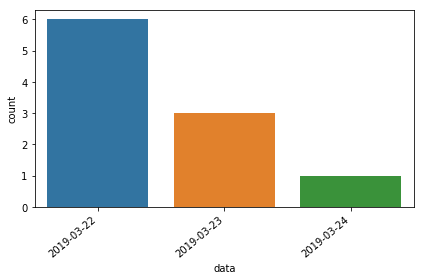

In [21]:
draw_graph_count(df_estranho, "data")

A palavra estranho também está relacionada ao mesmo tweet do usuário @oalexsimoes. A distribuição dos tweets que contém a palavra estranho, a partir do dia 22/03, é a mesma da palavra apaga a partir da mesma data.

## Contagem de frequência das palavras com polaridade Positiva

Listando as 10 mais frequentes

In [22]:
df_tweets_tokens_pos = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '1']
df_tweets_tokens_pos.groupby('tokens').tokens.count().nlargest(10)

tokens
energia       61
relevante     21
belo          10
voto           7
boa            3
cedo           3
certíssimo     3
eficiente      3
abençoada      2
aguenta        2
Name: tokens, dtype: int64

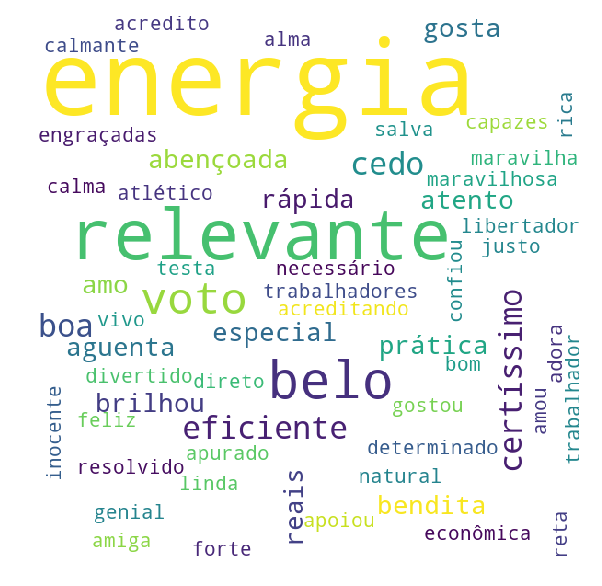

In [23]:
draw_word_cloud(df_tweets_tokens_pos.tokens)


In [24]:
df_energia = df_tweets_tokens_pos[['text','data','user_location']].loc[df_tweets_tokens_pos['tokens'] == 'energia']
df_energia.head(10)

,text,data,user_location
id,,,
1107125367767207936,CEMIG Serviços SA vocês conseguiriam me recomendar alguma empresa de fornecimento de energia elétrica A empresa,2019-03-17,0
1107138321044647938,ta faltando energia aqui Cemig bunita,2019-03-17,Timothy City
1107145095013433344,caiu a energia e vou dormir no valor valeu Cemig,2019-03-17,"Ipatinga, Minas Gerais"
1107338090975236097,que maravilha ein cemig sem estar chovendo to sem energia,2019-03-17,0
1107380419018797064,Eu tô pensando é como vamos trabalhar na segunda pós sunsetville mas tudo bem Cemig vai ter que me dar energia,2019-03-17,"Belo Horizonte, Minas Gerais"
1107417158668247040,Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17,+035
1107420107767275520,RT helenacarvlho Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17,Na puta que pariu
1107482804529565701,Caralho o motivo de ter acabado a energia é q pego fogo no negócio da Cemig slc bicho q medo desses troço,2019-03-18,"Itajubá, Brasil"
1107599066307969025,cemigenergia RT cemigenergia Efficientia A empresa de serviços de energia da Cemig vai investir até R 5,2019-03-18,Franca


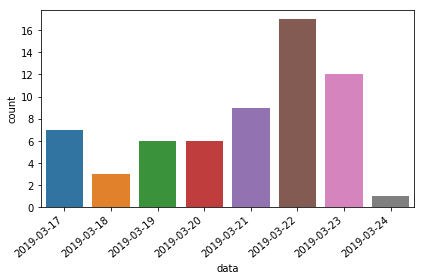

In [25]:
draw_graph_count(df_energia, "data")


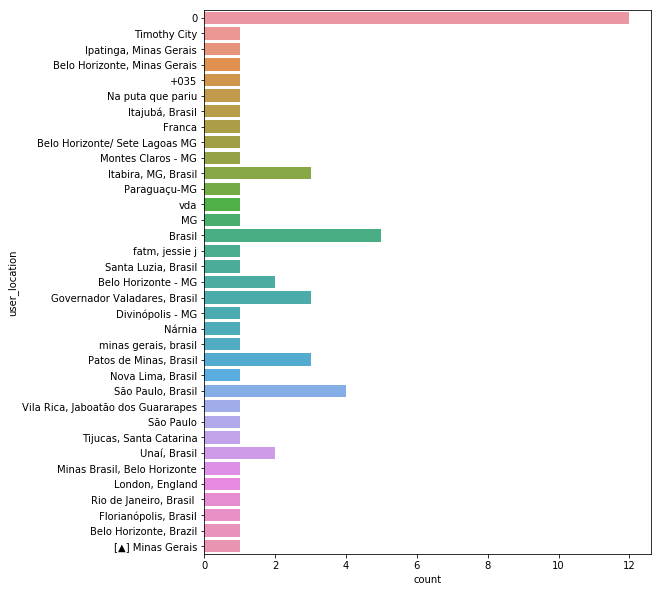

In [26]:
plt.figure(figsize=(8,10))
ax = sns.countplot(y="user_location", data=df_energia)
plt.show()

In [27]:
df_relevante = df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'relevante']
df_relevante.head(5)

,text,data
id,,
1109062517735731200,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22
1109062519933554688,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22
1109062601764495361,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22
1109062604159356928,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22
1109062646630887427,CMIG4 CEMIG CMIGN1 Fato Relevante 210319,2019-03-22


# Usuários mais influentes

## Usuários mais retweetados no período

In [28]:
df_retweets = df_tweets.loc[~(df_tweets['user_retweeted'] == "")]
df_retweets.groupby('user_retweeted').user_retweeted.count().nlargest(10)

user_retweeted
jornalhojeemdia    19
oalexsimoes         9
cemig_energia       6
em_com              6
AnaliseEnergia      5
GeraldodeMorais     3
gustavonolascoB     3
lopaugomes          3
lxcerdz             3
AssisMarinhodf      2
Name: user_retweeted, dtype: int64

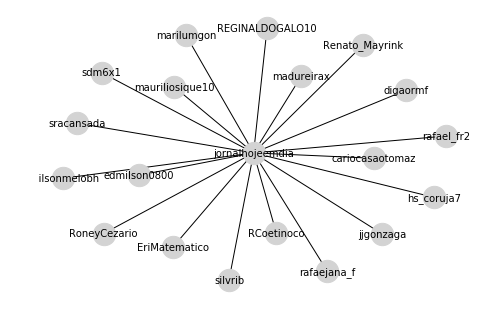

In [29]:
df_retweets_1 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="jornalhojeemdia")]
draw_network(df_retweets_1, df_retweets_1.user_screen_name, 'user_screen_name', 'user_retweeted')


In [30]:
df_retweets_1

,user_screen_name,user_retweeted,text
465,REGINALDOGALO10,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
467,digaormf,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
468,rafael_fr2,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
469,sracansada,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
471,hs_coruja7,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
473,silvrib,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
477,RCoetinoco,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
480,Renato_Mayrink,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
482,edmilson0800,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil
511,RoneyCezario,jornalhojeemdia,RT jornalhojeemdia Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil


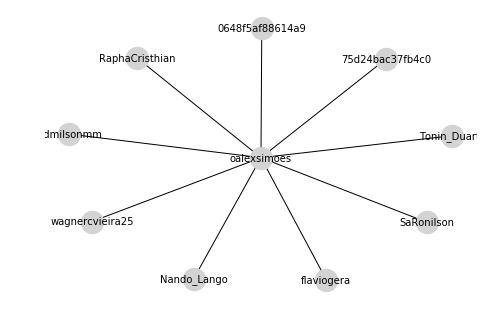

In [31]:
df_retweets_2 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="oalexsimoes")]
draw_network(df_retweets_2, df_retweets_2.user_screen_name, 'user_screen_name', 'user_retweeted')


In [32]:
df_retweets_2

,user_screen_name,user_retweeted,text
458,Tonin_Duarte,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
459,RaphaCristhian,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
461,Nando_Lango,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
463,0648f5af88614a9,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
483,Edmilsonmm,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
496,wagnercvieira25,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
519,SaRonilson,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
532,flaviogera,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern
565,75d24bac37fb4c0,oalexsimoes,RT oalexsimoes O cancelamento há apenas uma semana não apaga a necessidade de explicações Muito estranho Pelo menos o atual govern


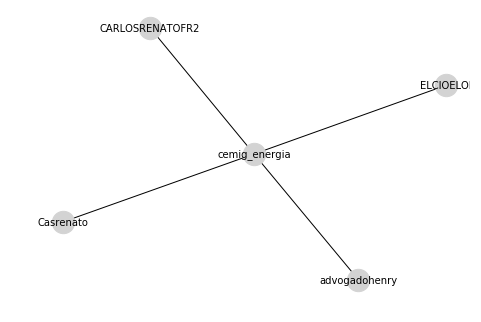

In [33]:
df_retweets_3 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="cemig_energia")]
draw_network(df_retweets_3, df_retweets_3.user_screen_name, 'user_screen_name', 'user_retweeted')


In [34]:
df_retweets_3

,user_screen_name,user_retweeted,text
69,advogadohenry,cemig_energia,RT cemigenergia A Cemig Geração Distribuída Cemig GD inaugurou em Janaúba no Norte de Minas a primeira usina de minigeração destinad
147,Casrenato,cemig_energia,RT cemigenergia As ligações clandestinas na rede elétrica os chamados gatos são uma prática perigosa e ilegal Fique atento Chame a
537,Casrenato,cemig_energia,RT cemigenergia Caso veja fios elétricos caídos sobre um veículo não se aproxime se estiver dentro dele evite sairCaso seja necessá
542,ELCIOELOI,cemig_energia,RT cemigenergia Caso veja fios elétricos caídos sobre um veículo não se aproxime se estiver dentro dele evite sairCaso seja necessá
604,Casrenato,cemig_energia,RT cemigenergia Mantenha sua geladeira ligada Desligar a geladeira durante a noite reduz a durabilidade de seus alimentos além de não
606,CARLOSRENATOFR2,cemig_energia,RT cemigenergia Mantenha sua geladeira ligada Desligar a geladeira durante a noite reduz a durabilidade de seus alimentos além de não


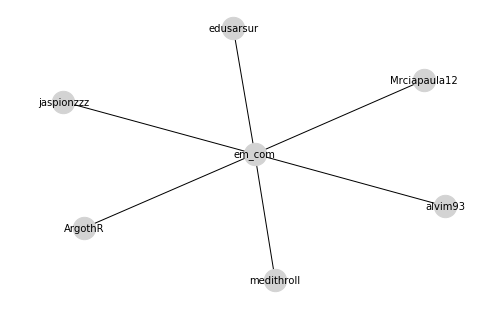

In [35]:
df_retweets_4 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="em_com")]
draw_network(df_retweets_4, df_retweets_4.user_screen_name, 'user_screen_name', 'user_retweeted')



In [36]:
df_retweets_4

,user_screen_name,user_retweeted,text
178,medithroll,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p
180,edusarsur,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p
187,alvim93,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p
188,ArgothR,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p
189,jaspionzzz,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p
197,Mrciapaula12,em_com,RT emcom Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comerciantes foram p


## Usuários com mais seguidores

In [37]:
df_tweets.groupby('user_screen_name').user_followers_count.max().nlargest(10)

user_screen_name
exame              2390173
em_com              497706
OficialBHTRANS      338156
otempo              276193
epocanegocios       209312
jornalhojeemdia     144154
portaluai            87909
CIObrasil            25533
cemig_energia        21620
SunoResearchcom      19466
Name: user_followers_count, dtype: int64

In [38]:
df_exame = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'exame']
df_exame.head(5)

,text,data
336,Conselho da Cemig GT aprova compra de fatia na Renova,2019-03-22


In [39]:
df_em_com = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'em_com']
df_em_com.head(5)

,text,data
177,Operação Blecaute da Polícia Civil em parceria com a Cemig foi feita na Região Noroeste da capital Dois comercia,2019-03-19


In [40]:
df_OficialBHTRANS = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'OficialBHTRANS']
df_OficialBHTRANS.head(5)


,text,data
315,19h45 AV AMAZONAS Sentido bairro Trânsito com trechos intensos mas fluindo entre Av do Contorno Expominas e,2019-03-21


In [41]:
df_otempo = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'otempo']
df_otempo.head(5)


,text,data
65,Marco Antônio Lage assume comunicação da Cemig mirando gestão eficiente,2019-03-18


In [42]:
df_epocanegocios = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'epocanegocios']
df_epocanegocios.head(5)


,text,data
407,Antes dos anúncios desta semana a Renova já havia recusado uma oferta da canadense Brookfield e da própria AES Tie,2019-03-22


In [43]:
df_jornalhojeemdia = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'jornalhojeemdia']
df_jornalhojeemdia.head(5)

,text,data
464,Cemig pagou R 990 mil por 3 anos de camarote no Independência no Mineirão preço seria R 390 mil,2019-03-22
538,Pelo aluguel por três anos de um camarote do Estádio Independência no Horto na região Leste de Belo Horizonte,2019-03-23
